In [1]:
## Evaluates the model with the id-8 weights trained to distinguish between volatility 0.3 and 0.6.

In [1]:
import torch
import tqdm
import numpy as np
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import os, sys
import pandas as pd
import json
import time
import socket
import matplotlib
import matplotlib.colors
from torch.backends import cudnn
import gc
sys.path.append("../")
try:
    from . import models as models
    from . import data_utils as data_utils
    from ..GRU_ODE_Bayes import models_gru_ode_bayes as models_gru_ode_bayes
except Exception:
    import NJODE.models as models
    import NJODE.data_utils as data_utils
    import GRU_ODE_Bayes.models_gru_ode_bayes as models_gru_ode_bayes
import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] =True
from sklearn.metrics import roc_auc_score

In [2]:
params_dict = {'batch_size': 100, 'bias': True, 'dataset': 'BlackScholes', 'dataset_id': None, 'dropout_rate': 0.1,
               'enc_nn': [[200, 'tanh'], [200, 'tanh']], 'epochs': 100, 'hidden_size': 10, 'input_size': 1,
               'learning_rate': 0.001, 'ode_nn': [[200, 'tanh'], [200, 'tanh']], 'paths_to_plot': [0, 1, 2, 3, 4],
               'plot': True, 'options': {'residual_enc_dec': True, 'which_loss': 'standard'}, 'output_size': 1,
               'readout_nn': [[200, 'tanh'], [200, 'tanh']], 'save_every': 5, 'seed': 398, 'solver': 'euler',
               'test_size': 0.2, 'use_rnn': True, 'weight': 0.5, 'weight_decay': 1.0, 'n_layers_classification': 3, 
               'activation_classification': 'relu','n_hidden_classification': 50,
               'dropout_rate_classification': 0}
params_dict = {"activation_classification": "relu", "batch_size": 100, "bias": True, "dataset": "BlackScholes_mixed", "dataset_id": 1621935452, "dropout_rate": 0.1, "dropout_rate_classification": 0, "enc_nn": [[200, "tanh"], [200, "tanh"]], "epochs": 100, "hidden_size": 10, "input_size": 1, "learning_rate": 0.001, "n_hidden_classification": 50, "n_layers_classification": 3, "ode_nn": [[200, "tanh"], [200, "tanh"]], "optimal_eval_loss": 0.35795466627947764, "options": {"evaluate": False, "residual_enc_dec": True, "which_loss": "standard"}, "output_size": 1, "readout_nn": [[200, "tanh"], [200, "tanh"]], "seed": 398, "solver": "euler", "test_size": 0.2, "use_rnn": False, "weight": 0.5, "weight_decay": 1.0}
learning_rate = 0.001
model = models.NJODE_classification(**params_dict)
model_name = 'NJODE'

device = torch.device("cpu")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                                 weight_decay=0.0005)
#load weights
model_path_save_last = '../data/saved_models/id-8_Euler/best_checkpoint/'
models.get_ckpt_model(model_path_save_last, model, optimizer, device)

using loss: standard
use residual network: input_size=1, output_size=10
use residual network: input_size=10, output_size=1
use residual network: input_size=1, output_size=10


In [3]:
## create a small data_set and use it to evaluate the model
#create dataset
### the dimension parameter has to be changed when generating 2 dim datasets
hyperparam_vol_0 = {
    'drift': 2., 'volatility': .3, 'mean': 4,
    'speed': 2., 'correlation': 0.5, 'nb_paths': 1000, 'nb_steps': 100,
    'S0': 1, 'maturity': 1., 'dimension': 1, 
    'obs_perc': 0.1,
    'scheme': 'euler', 'return_vol': False, 'v0': 1,
}
path,time_id = data_utils.create_mixed_dataset(hyperparam_dict = hyperparam_vol_0, vol1 = 0.6,seed = 23)

In [4]:
#load dataset
dataset = 'BlackScholes_mixed'
data = data_utils.IrregularMixedDataset(model_name=dataset, time_id=time_id)

dl = DataLoader(dataset = data, collate_fn = data_utils.custom_collate_fn_classification,shuffle  = True, batch_size = 1000, num_workers = 1)


../NJODE/models.py:608: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.Softmax()(out)


AUC: 

0.922586
Accuracy:

tensor(0.8520, dtype=torch.float64)

True label:0.0

Predicted probabilities:tensor([6.6111e-04, 9.9934e-01], grad_fn=<SliceBackward>)


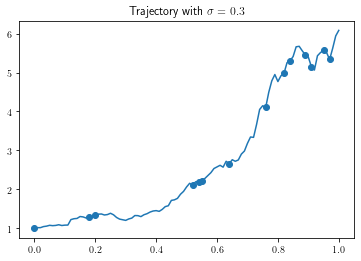

In [36]:
for batch in dl:
    times = batch["times"]
    time_ptr = batch["time_ptr"]
    X = batch["X"].to(device)
    start_X = batch["start_X"].to(device)
    obs_idx = batch["obs_idx"]
    T = 1
    delta_t = 0.01
    model.eval()
    res = model.get_pred(times, time_ptr, X, obs_idx, delta_t, T,
                                  start_X).to(device)
    #print(res)
    #print(torch.argmax(res,dim=1))
    print('AUC: \n')
    print(roc_auc_score(batch['labels'],res.detach()[:,1]))
    print('Accuracy:\n')
    print(1-torch.mean(np.abs(torch.argmax(res,dim=1).detach()-batch['labels'])))
    #label probabilities for the wrong classified paths
    #print(res[np.where(np.abs(torch.argmax(res,dim=1).detach()-batch['labels']))])
    
    #plot the trajectory + observation for missprediction as well as the predicted probabilities
    #index of the first wrong prediction
    ind_wrong = np.where(np.abs((torch.argmax(res,dim=1).detach()-batch['labels'])*torch.argmax(res,dim=1).detach()))[0][0]
    ind = np.nonzero(data.observed_dates[ind_wrong,:])
    plt.scatter(np.linspace(0,1,101)[ind],batch['true_paths'][ind_wrong,0,ind])
    plt.plot(np.linspace(0,1,101),batch['true_paths'][ind_wrong,0,:])
    vol = {0:0.3,1:0.6}
    plt.title('Trajectory with $\sigma = %.1f$'%(vol[batch['labels'][ind_wrong]]))
    plt.savefig('/home/onorevole/Desktop/Wrong_example.pdf')
    print('\nTrue label:' +str(batch['labels'][ind_wrong]))
    print('\nPredicted probabilities:'+str(res[ind_wrong,:]))